# ==========================

# HRV analysis with patients' current mood

* Dataset provided by SMC Professor J.A.
* Research Goal: Estimate or predict depressed/anxious status based on HRV dataset

In [1]:
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import keras_one_cycle_clr as ktool

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torchvision

from PIL import Image

In [2]:
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense , Activation, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras import  backend as K
from keras.optimizers import SGD
# from tensorflow.keras import utils as np_utils
# from tensorflow.keras.metrics import binary_focal_crossentropy
from sklearn import decomposition, metrics
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
# from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer

# from tqdm import tqdm
# from torch.autograd import Variable
# from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import cohen_kappa_score,f1_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from keras.callbacks import Callback
# from pytorch_tabnet.tab_model import TabNetClassifier

In [3]:
# ## Set this if you want to check all information from dataframe without ... auto.
# np.set_printoptions(threshold=np.inf, linewidth=np.inf) #inf = infinity 
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.width', 100)

# ==========================

# Data Handling

* 주요 outlier:
> 1. SRD 0.8 미만 혹은 1.0 초과
> 2. 이상심박동수(abnormal_hr) 5회 초과

In [4]:
hrv_ori = pd.read_csv('E:/RESEARCH/Datasets/HRV/JA/HRV_prep.csv')

In [5]:
hrv_ori.shape

(3687, 73)

In [6]:
hrv_ori.columns

Index(['subject', 'gender', 'age', 'auto_activity', 'auto_balance',
       'stress_resist', 'stress_index', 'tired', 'avg_hr', 'heart_stable',
       'abnormal_hr', 'sdnn', 'psi', 'tp', 'vlf', 'lf', 'hf', 'lfnorm',
       'hfnorm', 'lf_hf', 'rmssd', 'apen', 'srd', 'tsrd', 'tp_ln', 'vlf_ln',
       'lf_ln', 'hf_ln', 'main_dx', 'subtype', 'second_dx', 'third_dx',
       'depressed', 'guilty', 'suicide', 'insomnia_one', 'insomnia_two',
       'insomnia_three', 'activity', 'retard', 'tension', 'mental_anxiety',
       'physical_anxiety', 'gastric_symp', 'physical_symp', 'sexual_symp',
       'hypochondriac', 'weight_loss', 'disease_insight', 'HAMD', 'anxiety',
       'nervous', 'fear', 'insomnia', 'cognitive', 'depressed_feeling',
       'muscular', 'sensory', 'cardiovascular', 'respiratory',
       'gastrointenstinal', 'genitourinary', 'autonomic_system',
       'interview_act', 'HAMA', 'BDI-II', 'BAI', 'MDQ', 'HCL-32', 'HAMD_',
       'HAMA_', 'BDI_', 'BAI_'],
      dtype='object')

* 기기상의 오류로 인한 결측치를 제거해주자.

In [7]:
hrv_ori = hrv_ori[(hrv_ori.srd >=0.8) & (hrv_ori.srd <= 1.0)] ## srd outlier removed - there were 1424 outlier data
hrv_ori = hrv_ori[(hrv_ori.abnormal_hr) <= 5] ## abnormal heart rate outlier removed - there were 175 outlier data

In [8]:
hrv_ori.shape ## total 1491 data removed (outlier due to the hardware error)

(2196, 73)

In [9]:
data_bp = hrv_ori[(hrv_ori['main_dx']=="BP_I")|(hrv_ori['main_dx']=="BP_II")]

In [10]:
# data_bp.to_csv('E:/RESEARCH/Datasets/HRV/JA/HRV_bipolar.csv', index=False)

* 분석을 진행하다보니 한가지 문제가 HAMD, BDI // HAMA, BAI 로 나오는 우울/불안 정도가 다르다는 것이다.
> 따라서 depressed, anxious 라고 각 우울, 불안 지표가 같은 애들만 따로 추려보자.

In [11]:
hrv_ori['depression'] = 0
hrv_ori['anxious'] = 0

In [12]:
hrv_ori.head()

,subject,gender,age,auto_activity,auto_balance,stress_resist,stress_index,tired,avg_hr,heart_stable,...,BDI-II,BAI,MDQ,HCL-32,HAMD_,HAMA_,BDI_,BAI_,depression,anxious
0,A0001,F,64,50,76,59,150,150,82,50,...,19.0,7.0,2.0,11.0,mild,normal,moderate,normal,0,0
1,A0002,F,27,101,74,105,87,92,68,91,...,43.0,NaN,7.0,1.0,moderate,normal,severe,NaN,0,0
3,A0004,F,41,93,92,100,91,105,71,116,...,40.0,NaN,3.0,0.0,severe,severe,severe,NaN,0,0
4,A0006,F,47,81,53,73,124,109,86,82,...,21.0,10.0,4.0,12.0,mild,normal,moderate,mild,0,0
6,A0008,F,35,139,89,129,66,77,60,150,...,11.0,6.0,12.0,17.0,mild,mild,normal,normal,0,0


In [13]:
hrv_ori.loc[(hrv_ori['HAMD_']=="normal") & (hrv_ori['BDI_']=="normal"), 'depression' ] = 'normal'
hrv_ori.loc[(hrv_ori['HAMD_']=="mild") & (hrv_ori['BDI_']=="mild"), 'depression' ] = 'mild'
hrv_ori.loc[(hrv_ori['HAMD_']=="moderate") & (hrv_ori['BDI_']=="moderate"), 'depression' ] = 'moderate'
hrv_ori.loc[(hrv_ori['HAMD_']=="severe") & (hrv_ori['BDI_']=="severe"), 'depression' ] = 'severe'

In [14]:
hrv_ori.loc[(hrv_ori['HAMA_']=="normal") & (hrv_ori['BAI_']=="normal"), 'anxious' ] = 'normal'
hrv_ori.loc[(hrv_ori['HAMA_']=="mild") & (hrv_ori['BAI_']=="mild"), 'anxious' ] = 'mild'
hrv_ori.loc[(hrv_ori['HAMA_']=="moderate") & (hrv_ori['BAI_']=="moderate"), 'anxious' ] = 'moderate'
hrv_ori.loc[(hrv_ori['HAMA_']=="severe") & (hrv_ori['BAI_']=="severe"), 'anxious' ] = 'severe'

In [15]:
hrv_ori.head()

,subject,gender,age,auto_activity,auto_balance,stress_resist,stress_index,tired,avg_hr,heart_stable,...,BDI-II,BAI,MDQ,HCL-32,HAMD_,HAMA_,BDI_,BAI_,depression,anxious
0,A0001,F,64,50,76,59,150,150,82,50,...,19.0,7.0,2.0,11.0,mild,normal,moderate,normal,0,normal
1,A0002,F,27,101,74,105,87,92,68,91,...,43.0,NaN,7.0,1.0,moderate,normal,severe,NaN,0,0
3,A0004,F,41,93,92,100,91,105,71,116,...,40.0,NaN,3.0,0.0,severe,severe,severe,NaN,severe,0
4,A0006,F,47,81,53,73,124,109,86,82,...,21.0,10.0,4.0,12.0,mild,normal,moderate,mild,0,0
6,A0008,F,35,139,89,129,66,77,60,150,...,11.0,6.0,12.0,17.0,mild,mild,normal,normal,0,0


In [16]:
depression_empty = hrv_ori[hrv_ori['depression']==0].index
anxious_empty = hrv_ori[hrv_ori['anxious']==0].index
hrv_ori_dep = hrv_ori.drop(depression_empty)
hrv_ori_anx = hrv_ori.drop(anxious_empty)

In [17]:
print("The shape of the processed depression patients' hrv dataset is", hrv_ori_dep.shape)
print("The shape of the processed anxiety patients' hrv dataset is", hrv_ori_anx.shape)

The shape of the processed depression patients' hrv dataset is (599, 75)
The shape of the processed anxiety patients' hrv dataset is (510, 75)


In [18]:
hrv_ori_dep["depression"].value_counts()
# hrv_ori_anx["anxious"].value_counts()

depression
mild        189
moderate    145
severe      143
normal      122
Name: count, dtype: int64

In [ ]:
# hrv_ori_dep.to_csv('E:/RESEARCH/Datasets/HRV/JA/hrv_dep.csv', index=False)
# hrv_ori_anx.to_csv('E:/RESEARCH/Datasets/HRV/JA/hrv_anx.csv', index=False)

In [ ]:
hrv_ori = hrv_ori_dep

In [ ]:
hrv_ori

In [ ]:
hrv_ori.describe()

In [ ]:
# hrv_ori["HAMD"].describe()
# hrv_ori["HAMA"].describe()
# hrv_ori["BDI-II"].describe()
# hrv_ori["BAI"].describe()

In [ ]:
hrv_ori["gender"].value_counts()

In [ ]:
# Data export


## Gender, Age Separation

### 1) Gender

* select the "Female" dataset only

In [ ]:
# hrv_ori = hrv_ori[hrv_ori.gender == "F"]

* select the "Male" dataset only

In [ ]:
# hrv_ori = hrv_ori[hrv_ori.gender == "M"]

In [ ]:
hrv_ori.head()

### 2)  Age

In [ ]:
# hrv_ori = hrv_ori[(hrv_ori.age >=20) & (hrv_ori.age < 30)]

-------

## Data Separation

### Dataset variables

> "Demographic info" : Gender, Age \
> "Questionnaires" : HAMD, HAMA, BDI-II, BAI, MDQ, HCL-32 \
> "HRV's 17 Features" : SDNN, PSI, VLF, LF, HF, TP, LFNORM, HFNORM, LF/HF Ratio, RMSSD, APEN, SRD, TSRD, TP_ln, LF_ln, HF_ln \
> "Current Status labels":
>> HAMD_ : Hamilton Depression Rating Scale \
>> HAMA_ : Hamilton Anxiety Rating Scale \
>> BDI_ : Beck Depression Index \
>> BAI_ : Beck Anxiety Index \

In [ ]:
hrv_feature_list = ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln']
hrv_feature_list_core = ['sdnn', 'tp','vlf','lfnorm','hfnorm','rmssd','apen','srd','tsrd']

In [ ]:
hrv_hamd = hrv_ori.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln','HAMD_']]
hrv_hama = hrv_ori.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln','HAMA_']]
hrv_bdi = hrv_ori.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln','BDI_']]
hrv_bai = hrv_ori.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln','BAI_']]

In [ ]:
hrv_hamd_core = hrv_ori.loc[:, ['sdnn', 'tp','vlf','lfnorm','hfnorm','rmssd','apen','srd','rmssd','HAMD_']]
hrv_hama_core = hrv_ori.loc[:, ['sdnn', 'tp','vlf','lfnorm','hfnorm','rmssd','apen','srd','rmssd','HAMA_']]
hrv_bdi_core = hrv_ori.loc[:, ['sdnn', 'tp','vlf','lfnorm','hfnorm','rmssd','apen','srd','rmssd','BDI_']]
hrv_bai_core = hrv_ori.loc[:, ['sdnn', 'tp','vlf','lfnorm','hfnorm','rmssd','apen','srd','rmssd','BAI_']]

In [ ]:
hrv_dep = hrv_ori_dep.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln','depression']]
hrv_anx = hrv_ori_anx.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln','anxious']]

hrv_dep_core = hrv_ori_dep.loc[:, ['sdnn', 'tp','vlf','lfnorm','hfnorm','rmssd','apen','srd','rmssd','depression']]
hrv_anx_core = hrv_ori_anx.loc[:, ['sdnn', 'tp','vlf','lfnorm','hfnorm','rmssd','apen','srd','rmssd','anxious']]


hrv_dep_multi = hrv_ori_dep.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln',
                                 'auto_activity','auto_balance','stress_resist','stress_index','tired','avg_hr','heart_stable','abnormal_hr','depression']]
hrv_anx_multi = hrv_ori_anx.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln',
                                 'auto_activity','auto_balance','stress_resist','stress_index','tired','avg_hr','heart_stable','abnormal_hr','anxious']]

* Delete the patients with null value.

In [ ]:
hrv_hamd = hrv_hamd.dropna(subset = ['HAMD_'], axis=0)
hrv_hama = hrv_hama.dropna(subset = ['HAMA_'], axis=0)
hrv_bdi = hrv_bdi.dropna(subset = ['BDI_'], axis=0)
hrv_bai = hrv_bai.dropna(subset = ['BAI_'], axis=0)

In [ ]:
hrv_hamd_core = hrv_hamd_core.dropna(subset = ['HAMD_'], axis=0)
hrv_hama_core = hrv_hama_core.dropna(subset = ['HAMA_'], axis=0)
hrv_bdi_core = hrv_bdi_core.dropna(subset = ['BDI_'], axis=0)
hrv_bai_core = hrv_bai_core.dropna(subset = ['BAI_'], axis=0)

## Multimodality approach

In [ ]:
hrv_hamd_multi = hrv_ori.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln',
                                 'auto_activity','auto_balance','stress_resist','stress_index','tired','avg_hr','heart_stable','abnormal_hr','HAMD_']]
hrv_hama_multi = hrv_ori.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln',
                                 'auto_activity','auto_balance','stress_resist','stress_index','tired','avg_hr','heart_stable','abnormal_hr','HAMA_']]
hrv_bdi_multi = hrv_ori.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln',
                                 'auto_activity','auto_balance','stress_resist','stress_index','tired','avg_hr','heart_stable','abnormal_hr','BDI_']]
hrv_bai_multi = hrv_ori.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln',
                                 'auto_activity','auto_balance','stress_resist','stress_index','tired','avg_hr','heart_stable','abnormal_hr','BAI_']]

In [ ]:
hrv_hamd_multi = hrv_hamd_multi.dropna(subset = ['HAMD_'], axis=0)
hrv_hama_multi = hrv_hama_multi.dropna(subset = ['HAMA_'], axis=0)
hrv_bdi_multi = hrv_bdi_multi.dropna(subset = ['BDI_'], axis=0)
hrv_bai_multi = hrv_bai_multi.dropna(subset = ['BAI_'], axis=0)

In [ ]:
# hrv_hamd_multi

---------

# ==========================

## Data Selection

* Select the dataset for further analysis

In [ ]:
data = hrv_dep
# data = hrv_anx

In [ ]:
data.shape

In [ ]:
data

In [ ]:
# data["HAMD_"].value_counts()
# data["BDI_"].value_counts()

## Checking new variable counts
data["depression"].value_counts()
# data["anxious"].value_counts()

----------

## Data preprocessing

### Removing HRV outliers

In [ ]:
# feature_list = ['sdnn', 'psi', 'tp', 'vlf', 'lf', 'hf', 'lfnorm', 'hfnorm', 'lf_hf', 'rmssd', 'apen', 'srd', 'tsrd', 'tp_ln', 'vlf_ln', 'lf_ln', 'hf_ln']
# data_outlier = data.copy()

In [ ]:
# var = 'HAMD_'
# var = 'HAMA_'
# var = 'BDI_'
# var = 'BAI_'

## With new variables
var = 'depression'
# var = 'anxious'

In [ ]:
data[var].value_counts()

In [ ]:
normal = data[data[var]=='normal']
mild = data[data[var]=='mild']
moderate = data[data[var]=='moderate']
severe = data[data[var]=='severe']

In [ ]:
## check the data
normal

#### Removing outliers with q1, q2 quantile values

In [ ]:
# ## Removing outlier of each HRV feature variables.
# for feature in feature_list:
#     q1 = data[feature].quantile(0.25)
#     q3 = data[feature].quantile(0.75)
#     iqr = q3 - q1
#     condition = data[feature]>q3+(1.5*iqr)
#     ind = data[condition].index
#     data.drop(ind, inplace=True)

In [ ]:
data.shape

### Outliers check with boxplot

In [ ]:
normal = data[data[var]=='normal']
mild = data[data[var]=='mild']
moderate = data[data[var]=='moderate']
severe = data[data[var]=='severe']

In [ ]:
data_box = data.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen',
                                  'srd','tsrd', 'tp_ln', 'vlf_ln','lf_ln','hf_ln']]
normal_box = normal.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen',
                                  'srd','tsrd', 'tp_ln', 'vlf_ln','lf_ln','hf_ln']]
mild_box = mild.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen',
                                  'srd','tsrd', 'tp_ln', 'vlf_ln','lf_ln','hf_ln']]
moderate_box = moderate.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen',
                                  'srd','tsrd', 'tp_ln', 'vlf_ln','lf_ln','hf_ln']]
severe_box = severe.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen',
                                  'srd','tsrd', 'tp_ln', 'vlf_ln','lf_ln','hf_ln']]

In [ ]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = Normalizer()

In [ ]:
data_box[:] = scaler.fit_transform(data_box[:])
normal_box[:] = scaler.fit_transform(normal_box[:])
mild_box[:] = scaler.fit_transform(mild_box[:])
moderate_box[:] = scaler.fit_transform(moderate_box[:])
severe_box[:] = scaler.fit_transform(severe_box[:])

In [ ]:
# fig, ax = plt.subplots()
plt.figure(figsize = (10, 5))
sns.set_style("whitegrid")
plt.xlabel('HRV feature variables',fontsize=10)
plt.ylabel('Feature value',fontsize=10)
plt.boxplot(data_box)
plt.show()

In [ ]:
# fig, ax = plt.subplots()
plt.figure(figsize = (10, 5))
plt.xlabel('HRV feature variables',fontsize=10)
plt.ylabel('Feature value',fontsize=10)
plt.boxplot(normal_box)
plt.show()

In [ ]:
# fig, ax = plt.subplots()
plt.figure(figsize = (10, 5))
plt.xlabel('HRV feature variables',fontsize=10)
plt.ylabel('Feature value',fontsize=10)
plt.boxplot(mild_box)
plt.show()

In [ ]:
# fig, ax = plt.subplots()
plt.figure(figsize = (10, 5))
plt.xlabel('HRV feature variables',fontsize=10)
plt.ylabel('Feature value',fontsize=10)
plt.boxplot(moderate_box)
plt.show()

In [ ]:
# fig, ax = plt.subplots()
plt.figure(figsize = (10, 5))
plt.xlabel('HRV feature variables',fontsize=10)
plt.ylabel('Feature value',fontsize=10)
plt.boxplot(severe_box)
plt.show()

# ==========================

# Statistical Check and feature selection

In [ ]:
data_y = data.loc[:,[var]]

In [ ]:
# data

In [ ]:
data_x = data.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln']]
# data_x = data.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln',
#                                  'auto_activity','auto_balance','stress_resist','stress_index','tired','avg_hr','heart_stable','abnormal_hr']] ##for multimodality analysis
# data_x = data.loc[:, ['sdnn', 'tp', 'lf_hf', 'rmssd',  'srd', 'tsrd', 'tp_ln', 'vlf_ln', 'lf_ln', 'hf_ln']]
# data_x = data.loc[:,['sdnn', 'tp','vlf','lfnorm','hfnorm','rmssd','apen','srd','rmssd']]

## Scaler

In [ ]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = Normalizer()

In [ ]:
# scaler to normalize/standardize whole dataset
data_x[:] = scaler.fit_transform(data_x[:])

In [ ]:
data_var = ['sdnn', 'tp', 'vlf', 'lf', 'hf', 'lfnorm', 'hfnorm', 'lf_hf', 'rmssd', 'apen', 'srd', 'tsrd', 'tp_ln', 'vlf_ln', 'lf_ln', 'hf_ln']
# data_var = ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln',
#             'auto_activity','auto_balance','stress_resist','stress_index','tired','avg_hr','heart_stable','abnormal_hr']
# data_var_ = ['sdnn', 'tp', 'lf_hf', 'rmssd',  'srd', 'tsrd', 'tp_ln', 'vlf_ln', 'lf_ln', 'hf_ln']

## T-TEST, ANOVA

In [ ]:
## Comparing 4 groups (normal, mild, moderate, severe) with ANOVA test
stat_result =[]
for var in data_var:
    a = normal[var].values
    b = mild[var].values
    c = moderate[var].values
    d = severe[var].values
    f_val , p_val = stats.f_oneway(a, b, c, d)
    stat_result.append([f_val, p_val])

In [ ]:
stat_result = pd.DataFrame(stat_result, columns = ['F-value', 'p-value'])
stat_result = stat_result.assign(HRV_feature = data_var)

In [ ]:
stat_result

* Significant variables: SDNN, LF, HF, RMSSD, SRD, TSRD, TP, VLF

In [ ]:
data_x = data.loc[:, ['sdnn','psi','tp','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln']]
# data_x = data.loc[:, ['lf','hf','lf_hf','rmssd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln','auto_activity','stress_resist','stress_index','tired','avg_hr','heart_stable']]

## Support vector machine performance check

In [ ]:
# data_x
# data_y

In [ ]:
## Using 4 classes (normal vs mild vs moderate vs severe)
data_y = data_y.replace({'normal': 0})
data_y = data_y.replace({'mild': 1})
data_y = data_y.replace({'moderate': 2})
data_y = data_y.replace({'severe': 3})

In [ ]:
# data_y = to_categorical((data_y), 4)

* train, test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state = 710674)

In [ ]:
x_test.shape[0]

In [ ]:
print(x_train.shape)
print(y_train.shape)

### SVM

In [ ]:
from sklearn import svm

svm_correct = []
for i in range(500):
    clf = svm.SVC(random_state=710674, 
                  #class_weight=rf_class_w_dict,
                  kernel ='poly',
                  max_iter=i,
                  verbose=3
                 )    
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test).reshape(x_test.shape[0],1)
    test_correct = (predictions == y_test, 1)[0].sum().item()
    test_correct /= len(y_test)

    print(test_correct)
    svm_correct.append(test_correct)

In [ ]:
max(svm_correct)

### SVM-RFE (Recursive Feature Elimination)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
svm_rfe_correct = []

for i in range(500):
    estimator = svm.SVC(kernel="linear", C=1, 
                        #class_weight=rf_class_w_dict
                        max_iter=i,
                       )
    selector = RFE(estimator, step=1)

    selector = selector.fit(x_train, y_train)
    predictions = selector.predict(x_test).reshape(x_test.shape[0], 1)
    test_correct = (predictions == y_test, 1)[0].sum().item()
    test_correct /= len(y_test)

    print(test_correct)
    
    svm_rfe_correct.append(test_correct)



In [ ]:
max(svm_rfe_correct)

# ==========================

# Machine Learning approaches

In [ ]:
class Args:
    # arugments
    epochs=50
    bs=32
    lr=0.001
    momentum=0.9
    num_classes=4
    verbose='store_true'
    seed=710674

args = Args()    

# np.random.seed(args.seed)
# random.seed(args.seed)
# torch.manual_seed(args.seed)

In [ ]:
# print(data_x.dtypes)

---------

### Determine the number of classes(for prediction)

In [ ]:
## Using 4 classes (normal vs mild vs moderate vs severe)
label = data_y
# label = label.replace({'normal': 0})
# label = label.replace({'mild': 1})
# label = label.replace({'moderate': 2})
# label = label.replace({'severe': 3})

In [ ]:
label

In [ ]:
# ## Using 3 classes (normal vs mild vs moderate/severe)
# label = data_y
# label = label.replace({'normal': 0})
# label = label.replace({'mild': 1})
# label = label.replace({'moderate': 2})
# label = label.replace({'severe': 2})

In [ ]:
# ## Using 2 classes (normal vs depression)
# label = data_y
# label = label.replace({'normal': 0})
# label = label.replace({'mild': 1})
# label = label.replace({'moderate': 1})
# label = label.replace({'severe': 1})

-----------

In [ ]:
label.value_counts()

* Convert the y values into categorical variables

In [ ]:
y = to_categorical((label), 4)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size = 0.2, random_state = 710674)

In [ ]:
print("The size of training dataset is:", x_train.shape[0])
print("The size of test dataset is:", x_test.shape[0])

------

* For K-FOLD practice

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size = 0.2, random_state = 710674)

In [ ]:
inputs = np.concatenate((x_train, x_test), axis = 0)
targets = np.concatenate((y_train, y_test), axis = 0)

In [ ]:
inputs.shape

In [ ]:
targets.shape

----------------

### Model generation, selection

In [ ]:
## Generate the model
model = Sequential()
model.add(Dense(256, input_dim = x_train.shape[1], activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2)) #drop out
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(args.num_classes, activation = 'sigmoid'))

In [ ]:
# Generate the model-3
model = Sequential()
model.add(Dense(128, input_dim = x_train.shape[1], activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5)) #drop out
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(args.num_classes, activation = 'softmax'))

In [ ]:
# model.summary()

* Model 학습과정

In [ ]:
opt = keras.optimizers.SGD(learning_rate = args.lr, decay = 1e-5, momentum = args.momentum)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.fit(inputs[train], targets[train], batch_size = args.bs, epochs = args.epochs, verbose = 1, class_weight = class_weight)

In [ ]:
# scores = model.evaluate(inputs[test], targets[test])
# print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

* 5-FOLD CROSS VALIDATION approach

In [ ]:
fold_num = 1
split_num = 5
opt = keras.optimizers.SGD(learning_rate = args.lr, decay = 1e-6, momentum = args.momentum)
kfold = KFold(n_splits = split_num, shuffle = True)

In [ ]:
label.value_counts()

In [ ]:
# class_weight = {1:1, 0:1}
# class_weight = {1:1, 0:5}
# class_weight = {1:1, 2: 1.1 , 0:6}
# class_weight = {1:3, 2: 1.6 , 3: 1, 0:1.5}
# class_weight = {1:1, 2: 1.2 , 3: 1.2, 0:1.1}
class_weight = {1:1.7, 2: 4 , 3: 3.3, 0:1}

# class_weight = {1:1.1, 2: 1.1 , 3: 1.1, 0:1.1}

In [ ]:
acc_per_fold = []
loss_per_fold = []

In [ ]:
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    model.add(Dense(128, input_dim = x_train.shape[1], activation = 'relu'))
    model.add(Dense(512, activation = 'relu'))
    # model.add(Dense(1024, activation = 'relu'))
#     model.add(Dropout(0.5)) #drop out
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dense(1024, activation = 'relu')) 
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(256, activation = 'relu'))
    # model.add(Dense(128, activation = 'relu')) # added
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(args.num_classes, activation = 'softmax'))
    
    ## model compile
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
    print('----------------------------------------')
    print(f'Training or fold {fold_num} ... ')
    
    ## fit data to model
    history = model.fit(inputs[train], targets[train], batch_size = args.bs, epochs = args.epochs, verbose = 0, class_weight = class_weight)
    
    ## generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test])
    print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    ## increasing fold number
    fold_num = fold_num + 1
    
    
    
## Summarizing the results
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'>> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'>>> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'>>> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [ ]:
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    model.add(Dense(64, input_dim = x_train.shape[1], activation = 'relu'))
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(256, activation = 'relu'))
    # model.add(Dense(128, activation = 'relu')) # added
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(args.num_classes, activation = 'softmax'))
    
    ## model compile
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
    print('----------------------------------------')
    print(f'Training or fold {fold_num} ... ')
    
    ## fit data to model
    history = model.fit(inputs[train], targets[train], batch_size = args.bs, epochs = args.epochs, verbose = 0, class_weight = class_weight)
    
    ## generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test])
    print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    ## increasing fold number
    fold_num = fold_num + 1
    
    
    
## Summarizing the results
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'>> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'>>> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'>>> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [ ]:
model.summary()

In [ ]:
# for train, test in kfold.split(inputs, targets):
#     model = Sequential()
#     model.add(Dense(128, input_dim = x_train.shape[1], activation = 'relu'))
#     model.add(Dense(256, activation = 'relu'))
#     model.add(Dense(512, activation = 'relu'))
# #     model.add(BatchNormalization())
# #     model.add(Activation('relu'))
#     model.add(Dense(512, activation = 'relu'))
#     model.add(Dense(256, activation = 'relu'))
#     model.add(Dense(256, activation = 'relu'))
#     model.add(Dense(128, activation = 'relu')) # added
#     model.add(Dense(args.num_classes, activation = 'softmax'))
    
#     ## model compile
#     model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
#     print('----------------------------------------')
#     print(f'Training or fold {fold_num} ... ')
    
#     ## fit data to model
#     history = model.fit(inputs[train], targets[train], batch_size = args.bs, epochs = args.epochs, verbose = 0, class_weight = class_weight)
    
#     ## generate generalization metrics
#     scores = model.evaluate(inputs[test], targets[test])
#     print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
#     print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])
    
#     ## increasing fold number
#     fold_num = fold_num + 1

    
    
    
# ## Summarizing the results
# print('------------------------------------------------------------------------')
# print('Score per fold')
# for i in range(0, len(acc_per_fold)):
#     print('------------------------------------------------------------------------')
#     print(f'>> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
# print('------------------------------------------------------------------------')
# print('Average scores for all folds:')
# print(f'>>> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
# print(f'>>> Loss: {np.mean(loss_per_fold)}')
# print('------------------------------------------------------------------------')

In [ ]:
# print("Average classification accuracy is", (sum(acc_per_fold)/split_num))
# # print("Average classification loss is", (sum(loss_per_fold)/5))

In [ ]:
y_predict = model.predict(x_test)
y_predict = np.argmax(y_predict, axis = 1)
y_test = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test, y_predict, normalize = 'pred')
print(result)

In [ ]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(result, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

* sklearn.metrics 내의 함수를 통해 evaluation score 들을 파악해보자.
> 1. accuracy = (TP + TN) / (TP + TN + FP + FN) 
> 2. precision = TP / (TP + FP)
> 3. recall = TP / (TP + FN) 
> 4. f1 = (2 * precision * recall) / (precision + recall)

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = 'macro')
recall = metrics.recall_score(y_test, y_predict, average = 'micro')
f1 = metrics.f1_score(y_test, y_predict, average = 'weighted')

print("=============================================")
print("The overall accuracy is:", round(accuracy, 4))
print("The precision score is:", round(precision, 4))
print("The recall score is:", round(recall, 4))
print("The f1 score is:", round(f1, 4))
print("=============================================")

In [ ]:
# model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

* Setting class weight to reduce class imbalance issue

In [ ]:
label.value_counts()

In [ ]:
# class_weight = {1:1, 0:5}
class_weight = {1:1, 2: 1.1 , 0:5}

In [ ]:
model.fit(x_train, y_train, epochs = args.epochs, batch_size = args.bs, verbose=0, class_weight = class_weight)

In [ ]:
scores = model.evaluate(x_test, y_test)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-------------

----------

# ==========================

# Data Augmentation 

## 1. Using accessible Public Dataset

### 1) Date & feature selection

* 일단은 위에서 사용한 core dataset을 선정하자
1. RDATA = Real dataset (실제 분석에 사용하고자 하는 dataset)
2. PDATA = Public dataset (data augmentation을 위한 public dataset)

In [ ]:
RDATA_ = hrv_ori.loc[:, ['rmssd', 'avg_hr', 'vlf', 'lf', 'hf', 'tp', 'lf_hf', 'HAMD_']]
RDATA = RDATA_.drop(['HAMD_'], axis=1)

In [ ]:
PDATA_ = pd.read_csv('E:/RESEARCH/Datasets/HRV/HRV_Public/SWELL_hrv/data/final/train_for_augmentation.csv', sep=',')

In [ ]:
print("Original data shape is", RDATA_.shape)
print("Data for augmentation shape is", PDATA_.shape)

* SWELL dataset에는 세가지 status에 해당하는 HRV 값들이 있다. (no stress, interruption, time pressure)

In [ ]:
PDATA_base = PDATA_.loc[PDATA_.condition == 'no stress']
PDATA_stress = PDATA_.loc[(PDATA_.condition =='interruption') | (PDATA_.condition =='time pressure')]

* augmentation 에 사용하고자 하는 데이터 양이 너무 많아서 약간 줄여주자

In [ ]:
PDATA_ = PDATA_stress.sample(n=3000)

In [ ]:
# sns.pairplot(PDATA)

In [ ]:
# 일단 PDATA는 unlabeled dataset이라고 생각해주고 현재 라벨 버린 뒤, -1로 라벨값을 만들어주고,
PDATA = PDATA_.drop(['condition'], axis=1)
PDATA['y'] = -1

In [ ]:
PDATA.info()

* Real data에 어떤 변수들이 있는지 확인.


In [ ]:
RDATA.info()

* Real Data의 컬럼명을 PDATA랑 맞춰주자.

In [ ]:
RDATA.columns = ['RMSSD', 'HR', 'VLF', 'LF', 'HF', 'TP', 'LF_HF']

* Real data에서 target으로 삼을 label을 따로 추출해서 범주화

In [ ]:
target_ = RDATA_.loc[:, 'HAMD_']

In [ ]:
target_.shape

In [ ]:
## Using 4 classes (normal vs mild vs moderate vs severe)
target = target_
target = target.replace({'normal': 0})
target = target.replace({'mild': 1})
target = target.replace({'moderate': 2})
target = target.replace({'severe': 3})

In [ ]:
target.value_counts()

* Data augmentation을 위해 변수값들을 표준화 시켜주는 과정

In [ ]:
scaler = MinMaxScaler() #set the scaler

RDATA[:] = scaler.fit_transform(RDATA[:])
RDATA = RDATA.round(decimals=2)
PDATA[:] = scaler.fit_transform(PDATA[:])
PDATA = PDATA.round(decimals=2)

* 표준화하니까 데이터가 차원축소했을 때 설명력이 떨어져서 그냥 주석처리

* Real data는 차원축소를 진행해도 설명력을 충분히 가지는지 확인.

In [ ]:
Rpca_3 = decomposition.PCA(n_components=3)
Rpca_3_result = Rpca_3.fit_transform(RDATA)
Rtotal_var3 = Rpca_3.explained_variance_ratio_.sum()*100

# PCA를 통해 축소된 3차원이 어느정도의 대표성을 가지는지 확인하기 위함.
print('Explained variation per principal component: {}'.format(pca_3.explained_variance_ratio_))
print('Cumulative variance explained by 3 principal components: {:.2%}'.format(np.sum(Rpca_3.explained_variance_ratio_)))

In [ ]:
RDATA_pca = pd.DataFrame(Rpca_3.transform(RDATA), columns = ['PCA%i' % i for i in range(3)], index = RDATA.index)

In [ ]:
# Plot initialisation
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('PCA 3 result from Real HRV dataset', fontsize=12, fontweight='bold')
ax.scatter(RDATA_pca['PCA0'], RDATA_pca['PCA1'], RDATA_pca['PCA2'], cmap="Set2_r", s=60)
# plt.savefig('pca_result.png')

* 마찬가지로 augmentation을 위한 public data도 차원축소를 해도 설명력을 가지는지 확인.

In [ ]:
PDATA_ = PDATA.drop(['y'], axis = 1)

In [ ]:
Ppca_3 = decomposition.PCA(n_components=3)
Ppca_3_result = Ppca_3.fit_transform(PDATA_)
total_var3 = Ppca_3.explained_variance_ratio_.sum()*100

# PCA를 통해 축소된 3차원이 어느정도의 대표성을 가지는지 확인하기 위함.
print('Explained variation per principal component: {}'.format(Ppca_3.explained_variance_ratio_))
print('Cumulative variance explained by 3 principal components: {:.2%}'.format(np.sum(Ppca_3.explained_variance_ratio_)))

In [ ]:
PDATA_pca = pd.DataFrame(Ppca_3.transform(PDATA_), columns = ['PCA%i' % i for i in range(3)], index = PDATA.index)

In [ ]:
# Plot initialisation
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('PCA 3 result from Public HRV dataset', fontsize=12, fontweight='bold')
ax.scatter(PDATA_pca['PCA0'], PDATA_pca['PCA1'], PDATA_pca['PCA2'], cmap="Set2_r", s=60)
# plt.savefig('pca_result.png')

* Augmentation에 쓸 데이터를 나눠놓자. (real data 먼저)

In [ ]:
# Labeled datapoints and following labels.
x1, x3 = np.split(RDATA, [int(0.2*len(RDATA))])
y1, y3 = np.split(target, [int(0.2*len(target))])

In [ ]:
print(x1.shape)
print(x3.shape)
print(y1.shape)
print(y3.shape)

* 이번에는 public data체크하자.

In [ ]:
# Unlabeled datapoints and following labels.
x2 = PDATA.loc[:,['RMSSD', 'HR', 'VLF', 'LF', 'HF', 'TP', 'LF_HF']]
y2 = PDATA['y']

In [ ]:
print(x2.shape)
print(y2.shape)

* Real data(training 부분만)랑 Public data 합치자.

In [ ]:
# Concatenate
x12 = np.concatenate((x1, x2))
y12 = np.concatenate((y1, y2))

* Logistic Regression 통해서 라벨 데이터(Real dataset)을 체크해보자.

In [ ]:
index = ['Analysis Method', 'ROC AUC']
results = pd.DataFrame(columns = index)

In [ ]:
np.isnan(x1.any())

In [ ]:
np.any(np.isnan(x1))

In [ ]:
np.all(np.isfinite(x1))

In [ ]:
logreg = LogisticRegression(random_state = 710674, class_weight = 'balanced')
logreg.fit(x1, y1)
results = results.append(
    pd.Series(['Logistic Regression', roc_auc_score(y3, logreg.predict_proba(x3), multi_class='ovr')],
              index=index), ignore_index=True)

In [ ]:
y1

## 2. Using its own Dataset

***

* Practices

In [41]:
# hrv_ori['main_dx'].value_counts()
hrv_ori.shape

(2196, 73)

* MDDs, MDDr, PDD
* BP_I, BP_II

In [42]:
data_mdd = hrv_ori[(hrv_ori['main_dx']=="MDDs")|(hrv_ori['main_dx']=="MDDr")|(hrv_ori['main_dx']=="PDD")]

In [43]:
# data_mdd.shape
data_mdd.columns

Index(['subject', 'gender', 'age', 'auto_activity', 'auto_balance',
       'stress_resist', 'stress_index', 'tired', 'avg_hr', 'heart_stable',
       'abnormal_hr', 'sdnn', 'psi', 'tp', 'vlf', 'lf', 'hf', 'lfnorm',
       'hfnorm', 'lf_hf', 'rmssd', 'apen', 'srd', 'tsrd', 'tp_ln', 'vlf_ln',
       'lf_ln', 'hf_ln', 'main_dx', 'subtype', 'second_dx', 'third_dx',
       'depressed', 'guilty', 'suicide', 'insomnia_one', 'insomnia_two',
       'insomnia_three', 'activity', 'retard', 'tension', 'mental_anxiety',
       'physical_anxiety', 'gastric_symp', 'physical_symp', 'sexual_symp',
       'hypochondriac', 'weight_loss', 'disease_insight', 'HAMD', 'anxiety',
       'nervous', 'fear', 'insomnia', 'cognitive', 'depressed_feeling',
       'muscular', 'sensory', 'cardiovascular', 'respiratory',
       'gastrointenstinal', 'genitourinary', 'autonomic_system',
       'interview_act', 'HAMA', 'BDI-II', 'BAI', 'MDQ', 'HCL-32', 'HAMD_',
       'HAMA_', 'BDI_', 'BAI_'],
      dtype='object')

In [45]:
# data_mdd.to_csv('E:/RESEARCH/Datasets/HRV/JA/HRV_mdd_main.csv', index=False)

In [28]:
# data_mdd_multi = data_mdd.loc[:, ['sdnn','psi','tp','vlf','lf','hf','lfnorm','hfnorm','lf_hf','rmssd','apen','srd','tsrd','tp_ln', 'vlf_ln','lf_ln','hf_ln',
#                                  'auto_activity','auto_balance','stress_resist','stress_index','tired','avg_hr','heart_stable','abnormal_hr','main_dx']]


data_mdd_all = data_mdd.drop(['subject','gender','age','subtype', 'second_dx','third_dx','HAMD_','HAMA_','BDI_','BAI_', 'depressed'],axis=1)

In [29]:
data_mdd_all.columns

Index(['auto_activity', 'auto_balance', 'stress_resist', 'stress_index',
       'tired', 'avg_hr', 'heart_stable', 'abnormal_hr', 'sdnn', 'psi', 'tp',
       'vlf', 'lf', 'hf', 'lfnorm', 'hfnorm', 'lf_hf', 'rmssd', 'apen', 'srd',
       'tsrd', 'tp_ln', 'vlf_ln', 'lf_ln', 'hf_ln', 'main_dx', 'guilty',
       'suicide', 'insomnia_one', 'insomnia_two', 'insomnia_three', 'activity',
       'retard', 'tension', 'mental_anxiety', 'physical_anxiety',
       'gastric_symp', 'physical_symp', 'sexual_symp', 'hypochondriac',
       'weight_loss', 'disease_insight', 'HAMD', 'anxiety', 'nervous', 'fear',
       'insomnia', 'cognitive', 'depressed_feeling', 'muscular', 'sensory',
       'cardiovascular', 'respiratory', 'gastrointenstinal', 'genitourinary',
       'autonomic_system', 'interview_act', 'HAMA', 'BDI-II', 'BAI', 'MDQ',
       'HCL-32'],
      dtype='object')

In [30]:
data_vis = data_mdd_all.copy()
data_vis = data_vis.drop(['main_dx'], axis=1)

In [35]:
data_vis = data_vis.fillna(data_vis.mean())

In [36]:
features = [col for col in list(data_vis.columns)]

In [37]:
features

['auto_activity',
 'auto_balance',
 'stress_resist',
 'stress_index',
 'tired',
 'avg_hr',
 'heart_stable',
 'abnormal_hr',
 'sdnn',
 'psi',
 'tp',
 'vlf',
 'lf',
 'hf',
 'lfnorm',
 'hfnorm',
 'lf_hf',
 'rmssd',
 'apen',
 'srd',
 'tsrd',
 'tp_ln',
 'vlf_ln',
 'lf_ln',
 'hf_ln',
 'guilty',
 'suicide',
 'insomnia_one',
 'insomnia_two',
 'insomnia_three',
 'activity',
 'retard',
 'tension',
 'mental_anxiety',
 'physical_anxiety',
 'gastric_symp',
 'physical_symp',
 'sexual_symp',
 'hypochondriac',
 'weight_loss',
 'disease_insight',
 'HAMD',
 'anxiety',
 'nervous',
 'fear',
 'insomnia',
 'cognitive',
 'depressed_feeling',
 'muscular',
 'sensory',
 'cardiovascular',
 'respiratory',
 'gastrointenstinal',
 'genitourinary',
 'autonomic_system',
 'interview_act',
 'HAMA',
 'BDI-II',
 'BAI',
 'MDQ',
 'HCL-32']

In [38]:
def kdeplot_features(data, feature, title):
    
    df0 = data[data['main_dx']=="MDDs"]
    df1 = data[data['main_dx']=="MDDr"]
    df2 = data[data['main_dx']=="PDD"]

    df0 = df0.drop(['main_dx'], axis=1)
    df1 = df1.drop(['main_dx'], axis=1)
    df2 = df2.drop(['main_dx'], axis=1)
    
    df0_values = df0[feature].to_numpy()
    df1_values = df1[feature].to_numpy()
    df2_values = df2[feature].to_numpy()
     
    plt.figure(figsize = (6, 2.5))
    
    sns.kdeplot(df0_values, color = 'b')
    sns.kdeplot(df1_values, color = 'r')
    sns.kdeplot(df2_values, color = 'y')
    
    plt.title(title, fontsize=15)
    plt.legend()
    plt.show();
    
    # del values_train , values_test
    # gc.collect()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


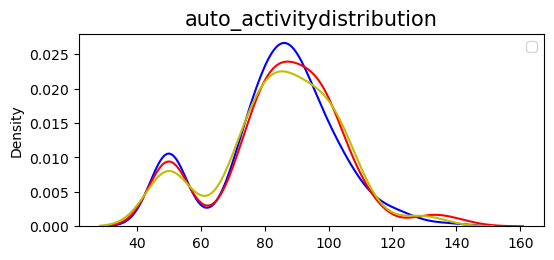

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


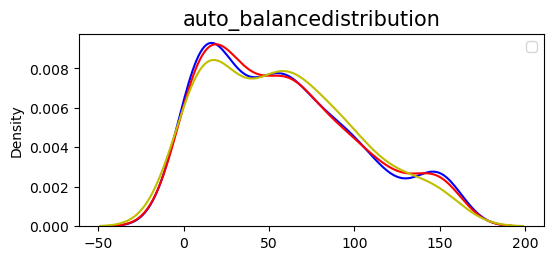

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


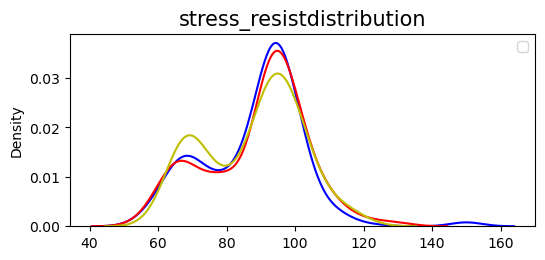

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


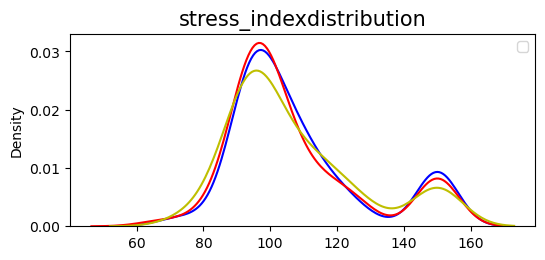

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


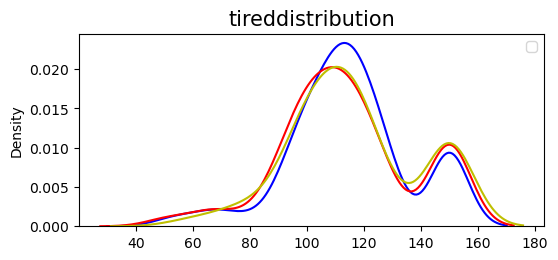

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


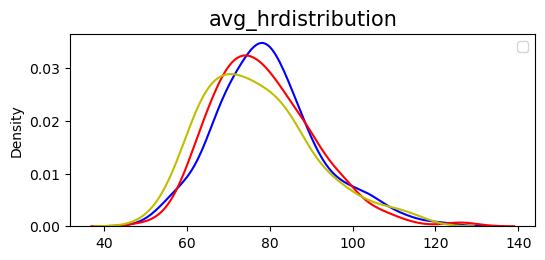

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


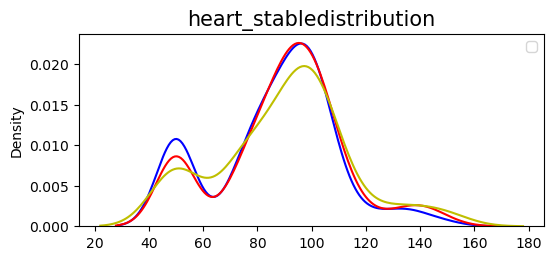

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


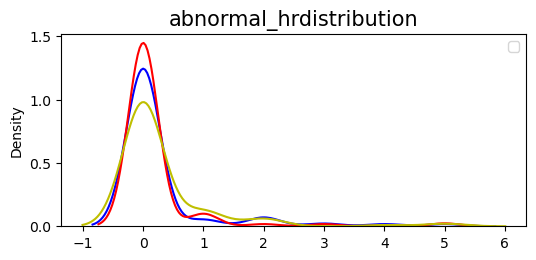

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


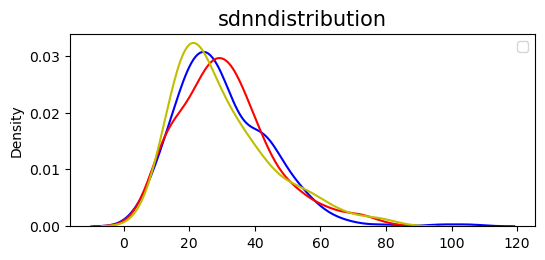

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


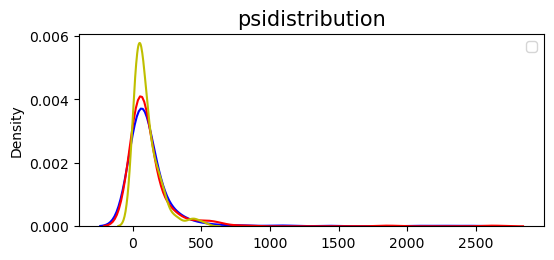

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


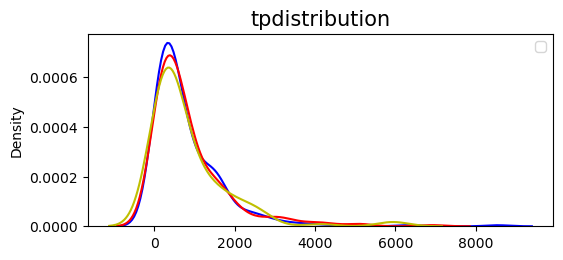

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


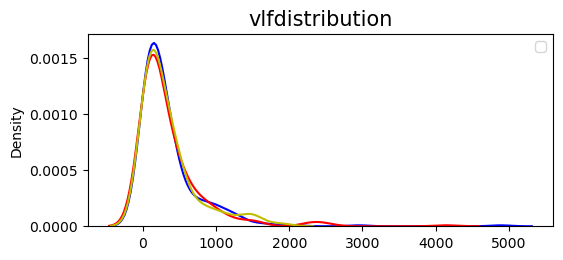

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


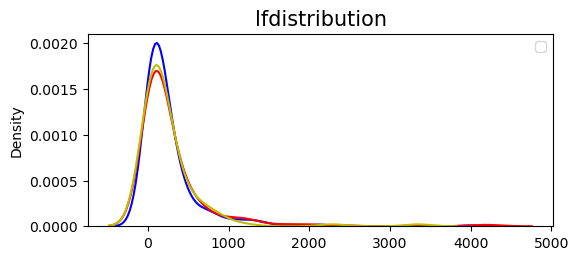

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


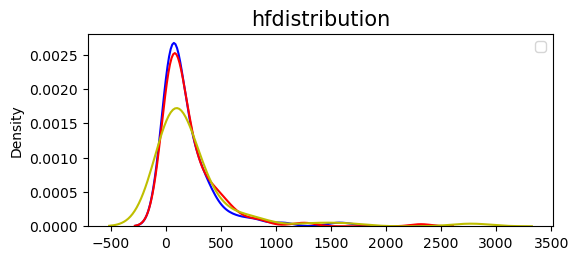

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


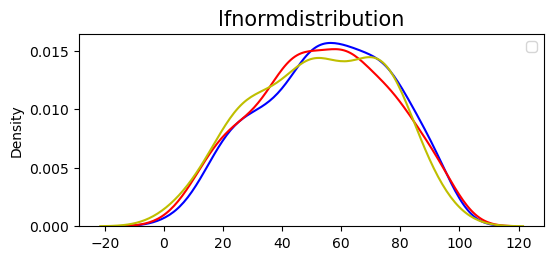

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


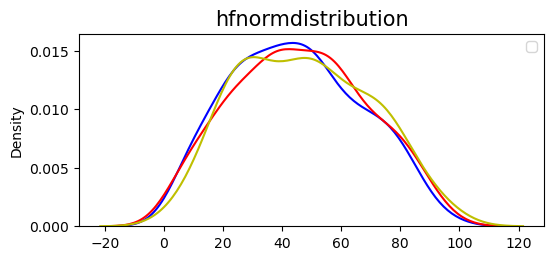

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


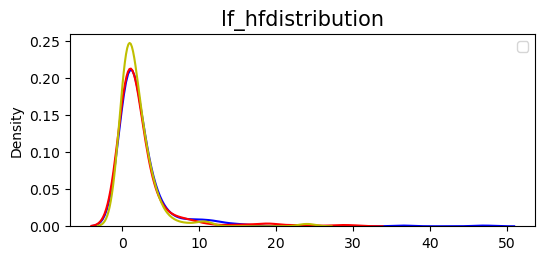

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


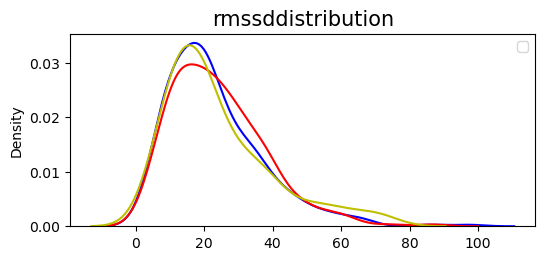

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


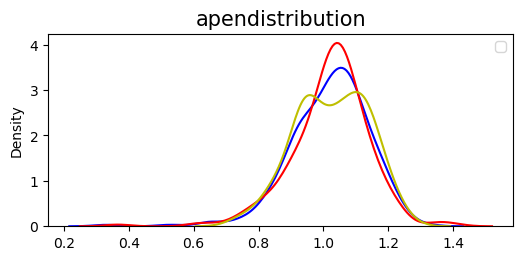

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


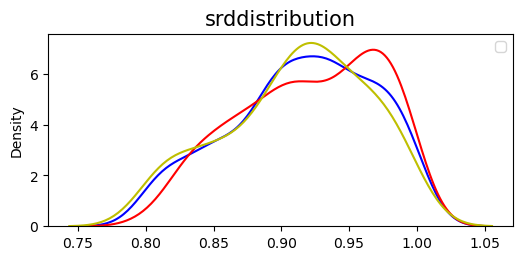

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


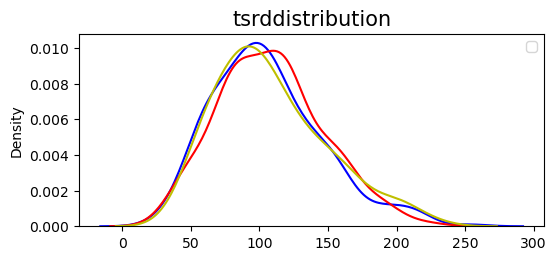

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


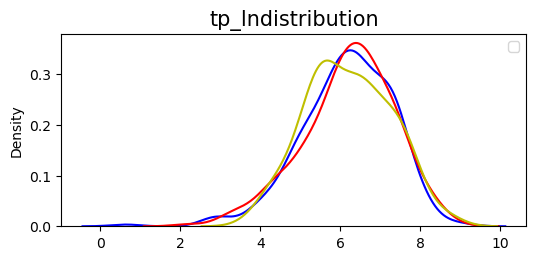

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


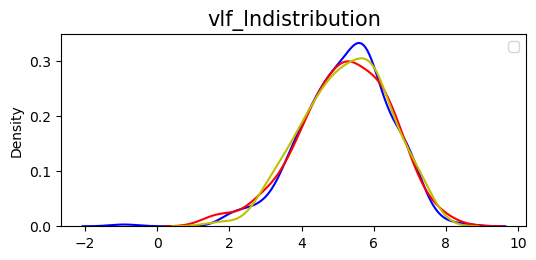

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


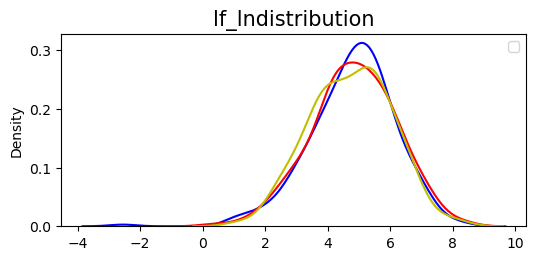

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


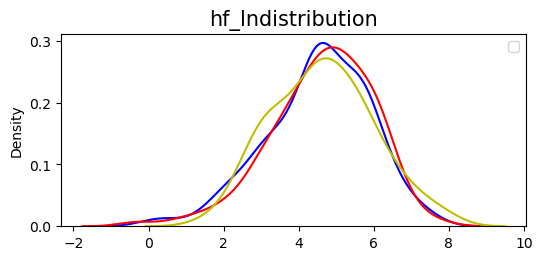

KeyError: 'guilty'

In [39]:
for var in features:
    kdeplot_features(data_mdd_multi, feature=var, title = var + "distribution")